In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

df_t = pd.read_csv('QandA.csv')

# Tokenizer
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Stemmer
from nltk.stem.porter import PorterStemmer

porter_stemmer = PorterStemmer()
def stem_words(word_list):
    '''
    Stem words
    
    Input:
    -----------------------
    List of words
    
    Return:
    ------------------------
    List of stemmed words
    '''
    return [porter_stemmer.stem(words) for words in word_list]

# lemmatizer
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize_words(word_list):
    '''
    Lemmatize words
    
    Input:
    -----------------------
    List of words
    
    Return:
    ------------------------
    List of lemmatized words
    '''
    return [wordnet_lemmatizer.lemmatize(words) for words in word_list]

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['hello', 'hi', 'welcom', 'headout', 'know', 'experi', 'refer', 'help', 'ani', 'chat', 'problem', 'may', 'reach', 'need', 'let', 'u', 'feel', 'free', 'contact', 'realli', 'appreci', 'could', 'rate', 'chat', 'thank', 'today', 'wa', 'nice', 'talk', 'great', 'day', 'goodby', 'would', 'like','plea', 'wait', 'minut', 'check', 'thi', 'anyth', 'el', 'step', 'away', 'assist', 'custom', 'bye', 'hey', 'ok','get', 'ye', 'safari', 'khalifa', 'burj', 'aquarium', 'roman', 'palatin', 'vatican', 'dubai'])
def remove_stopwords(word_list, stop_words):
    '''
    Remove stop words
    
    Input:
    -----------------------
    List of words
    
    Return:
    ------------------------
    List of words with stop words removed
    '''
    return [word for word in word_list if word not in stop_words]

# Combine all
def preprocess(text):
    return remove_stopwords(lemmatize_words(stem_words(tokenizer.tokenize(text.lower()))), stop_words)
preprocess('I will be stepping away get to assist notastopword other customers now, bye! :)')

['notastopword']

In [4]:
# Preprocess transcripts
df_l = df_t.QandA.apply(lambda s: ' '.join(preprocess(s)))

# Anchored CorEx modeling

In [89]:
from corextopic import corextopic as ct
# Build vocabulary list for CorEx topic model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english', max_features=20000, binary=True)
# Corpus
corpus = cv.fit_transform(df_l)
# Vocabulary
words = list(np.asarray(cv.get_feature_names()))

# Anchor Words for Anchored CorEx
anchor_words = [['cashback', 'cash'], 
                ['refund', 'cancel'], 
                ['child', 'adult','year','old','age','kid'], 
                ['seat', 'choos','select','section','offic','exact','togeth'],
                ['discount','coupon','code','offer'],
                ['card','payment','work','complet','error','issu','differ','tri'],
                ['pm','morn','night']
               ]

# Build model
ntopic = 25
topic_model = ct.Corex(n_hidden=ntopic, max_iter=200, seed=100)
topic_model.fit(corpus, words=words, anchors=anchor_words, anchor_strength=10)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: cashback,cash,wallet,log,facebook,user,creat,futur,virtual,account
1: cancel,refund,polici,strict,reschedul,di,amend,non,money,sono
2: adult,child,year,old,age,kid,abov,yr,18,daughter
3: seat,select,choos,offic,section,exact,togeth,box,map,assign
4: offer,discount,code,coupon,promo,love,wow,appli,unfortun,promot
5: tri,card,differ,work,issu,payment,complet,error,credit,debit
6: pm,night,morn,00,30,10,wish,dure,departur,depart
7: com,http,www,unit,emir,gmail,link,variantid,support,write
8: ticket,buy,purchas,tower,eiffel,onlin,collect,sell,counter,broadway
9: guid,tour,museum,colosseum,access,chapel,sistin,forum,audio,rome
10: meet,versail,point,palac,host,track,pari,specif,outsid,voucher
11: good,pleasur,nope,abt,hv,43,ill,mate,merci,tx
12: cruis,combo,arab,world,pas,dinner,river,singapor,park,zoo
13: id,sagrada,familia,order,sent,send,mail,told,barcelona,proof
14: hotel,pick,peter,st,drop,basilica,la,dune,por,pickup
15: paid,request,intellig,york,best,new,king,lion,school,rock
16: 

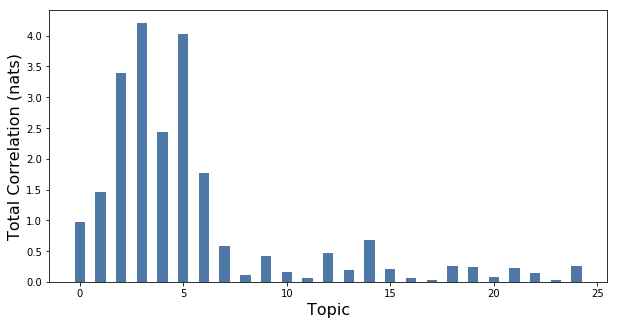

In [90]:
# Check Total Correlation for all topics
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

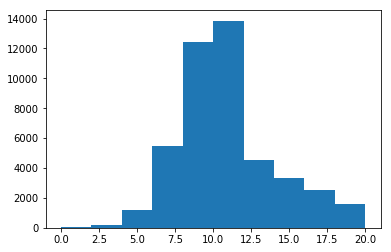

In [91]:
# Pointwise TC distribution
plt.hist(topic_model.log_z.sum(1), range=[0,20])
plt.show()

In [94]:
# Documents topic dataframe
df_top = pd.DataFrame(columns = ['logsum','topic','PTC'])
TC = topic_model.log_z
df_top['logsum'] = TC.sum(1)
df_top['topic'] = TC.argmax(1)
# Calculate Pointwise TC for each document
doc_cor = []
for i,row in df_top.iterrows():
    doc_cor.append(TC[i,int(row.topic)])
df_top['PTC'] = doc_cor

In [156]:
# Percentage of each topic
df_perc = pd.DataFrame(columns=['topic_no','percentage','keywords'])
df_perc['topic_no'] = list(i for i in range(ntopic))
rowN = float(df_top.shape[0])
for i in range(ntopic):
#     Calculate percentage
    df_perc.at[i,'percentage'] = df_top.loc[(df_top.topic == i) & (df_top.PTC > 8)].shape[0]/rowN
#     Key words
    topic_words,_ = zip(*topics[i])
    df_perc.at[i,'keywords'] = ' ,'.join(topic_words)
    
df_perc.head(7)

,topic_no,percentage,keywords
0,0,0.0143095,"cashback ,cash ,wallet ,log ,facebook ,user ,c..."
1,1,0.0293442,"cancel ,refund ,polici ,strict ,reschedul ,di ..."
2,2,0.0447416,"adult ,child ,year ,old ,age ,kid ,abov ,yr ,1..."
3,3,0.0493805,"seat ,select ,choos ,offic ,section ,exact ,to..."
4,4,0.0526292,"offer ,discount ,code ,coupon ,promo ,love ,wo..."
5,5,0.0459202,"tri ,card ,differ ,work ,issu ,payment ,comple..."
6,6,0.0473557,"pm ,night ,morn ,00 ,30 ,10 ,wish ,dure ,depar..."


# Visualization

In [245]:
from scipy.optimize import curve_fit
from wordcloud import WordCloud

## Refund

In [243]:
topic_words, proba = zip(*topic_model.get_topics(topic=4, n_words=40))

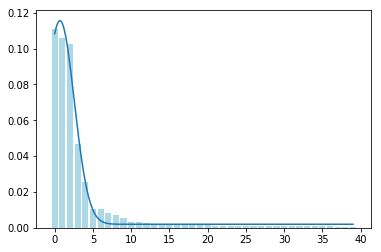

In [276]:
# Fitting
x = list(range(40))
fit = lambda x, A, x0, sigma, offset:  offset+A*np.exp(-((x-x0)/sigma)**2)
popt, pcov = curve_fit(fit, x, proba, p0=[1,0,1,0])


fig, ax = plt.subplots()

ax.bar(x, proba, color="lightblue", zorder=0)

x = np.linspace(min(x),max(x),250)
ax.plot(x, fit(x,*popt))
plt.show()

In [171]:
topic_model.get_topics(topic=1, n_words=100)[1]

('refund', 0.0865205673919861)

In [143]:
topic_words

('line',
 'skip',
 'summit',
 'secur',
 'queue',
 'climb',
 'euro',
 'elev',
 'romano',
 'coliseo')

In [ ]:
topic_model.get_topics(topic=0, n_words=20)

In [134]:
df_top.loc[(df_top.topic == 6) & (df_top.PTC > 8)].shape[0]/rowN

0.047355696585071015

In [136]:
rowN

66180

In [122]:
df_top.loc[(df_top.topic == 6) & (df_top.PTC > 8)].shape[0]

(66180, 3)

In [117]:
df_top.loc[(df_top.topic == 6) & (df_top.PTC > 8)].shape

(3134, 3)

In [88]:
df_l[952]

'bird park morn night even long doe take complet bird park jurong bird park open 8 30 6 00 pm daili night singapor open 7 30 pm 12 00 daili take anytim 1 hour 3 hour depend wish'

In [119]:
df_t.QandA[360]

' From which hotels do we have shuttles for IMg world I wanted to enquire about the pickup Hi One moment Please find the list of hotels and schedule for the Morning Shuttle Service to IMG Worlds of Adventure here. \nhttps://cdn-imgix-open.headout.com/product-images/IMG/Morning_shuttle_service-01.jpg'

In [116]:
df_l.loc[(df_top.topic == 6) & (df_top.PTC > 8)]

7                            madam though apolog night sir
60                           madam though apolog night sir
113                          madam though apolog night sir
191      pm 7 30 top open 8 30 11 00 pm ticket avail ti...
270      pm 7 30 top open 8 30 11 00 pm ticket avail ti...
332      zoo local oper sorri inconveni late local oper...
333                    cau drop email sorri inconveni morn
334                               cau morn drop email okay
338      gap two academia uffizi galleri tour one quest...
349      want book night hotel transfer upon hotel hote...
353      also ticket avail septemb 29th diner cruis x 6...
360      hotel shuttl img world want enquir pickup one ...
376      tomowro time start morn icc land park mayb rec...
378         17 date go anytim 10 6 pm mention right ticket
395      zoo local oper sorri inconveni late local oper...
396                    cau drop email sorri inconveni morn
397                               cau morn drop email ok

In [46]:
pd.Series(topic_model.log_z.argmax(1)).value_counts()

5     33481
3      6054
6      4221
2      3774
4      3523
1      1899
7      1871
12     1664
9      1532
14     1415
0      1013
21      837
24      762
10      638
13      566
18      540
22      510
15      409
19      366
20      342
8       293
16      273
11       85
23       78
17       34
dtype: int64